# Part 2: Creation of User Profiles
The goal of this notebook is to enrich the given data with different types of information. This information is centered around some "psychological" factors, such as sentiments and emotionality of the reviews, as well as "behaviour" factors, like favourite places or given ratings. General information such as gender and education is also added.
We start by importing the cleaned data (see notebook 1 for data preparation). Note: If the notebook is to be run, the appendix must be executed first.

**Table of Contents**
1. [Data read-in](#read_in) 
2. [Wordcloud](#wordcloud)
3. [Enrichment of the data](#enrichment)\
    3.1 [Review Lengths](#length)\
    3.2 [Sentiment Analysis](#sentiment)\
    3.3 [Emotionality Analysis](#emotionality)\
    3.4 [Readability Analysis](#readability)\
    3.5 [Profanity Check](#profanity)\
    3.6 [Gender Information](#gender)\
    3.7 [Education Information](#education)
4. [Sanity Check for Sentiments and Emotionality](#sanitycheck)
5. [Aggregating User Profiles](#profiles)\
    5.1 [Adding high-level category](#highlevel)\
    5.2 [Adding top emotion to top category](#top_emotion)\
    5.3 [Adding top locations](#top_states)
6. [Conclusions](#conclusions)
7. [References](#ref)
8. [Appendix](#append)

<a id='read_in'></a>
## 1. Data read-in
In the following, we read in the data that was prepared in notebook 1. We further remove embedded newlines and leading and trailing whitespace from the reviews.

In [ ]:
#read in the data
df = pd.read_csv('Clean_dataset_google_local_data_with_3+_reviews.csv', lineterminator = '\n')
df.head(3)

,placeID,name,lat,long,address,price_clean,country,state,username,userID,...,date,time,lang,currentPlace,education,jobs,previousPlaces,category,category1,count\r
0,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jul 4, 2013",1.372999e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],"['Marina', 'Recreation', 'Fishing Lake']",Marina,19
1,117477090906709658119,Pins & Needles Pro Shop,33.747513,-116.998209,"2850 W Florida AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jul 12, 2013",1.373637e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],['Bowling Supply Shop'],Bowling Supply Shop,19
2,118090863044520175763,Naval Base Ventura County: Point Mugu,34.118670,-119.119901,"311 Main Rd #1Point Mugu, CA 93042",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jun 25, 2013",1.372175e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],['Naval Base'],Naval Base,19


In [ ]:
df.shape

(1610141, 22)

In [ ]:
#remove embedded newlines and leading and trailing whitespace from the reviews
def newlines_whitespace(text):
    text = text.replace('\n',' ')
    
    #whitespace
    text = text.strip()
    return text

df['review'] = df['review'].apply(lambda x: newlines_whitespace(x))

<a id='wordcloud'></a>
## 2. Wordcloud

To gain a first overview over the reviews, we create a wordcloud. Because the code is rather memory-intensive, we restrict the data to a random sample with 500.000 entries.

In [ ]:
#code is taken from Lecture 2 ("Text Analysis - Part 1: Spam Classification")
def show_wordcloud(data, title):
    text = ' '.join(data['review'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

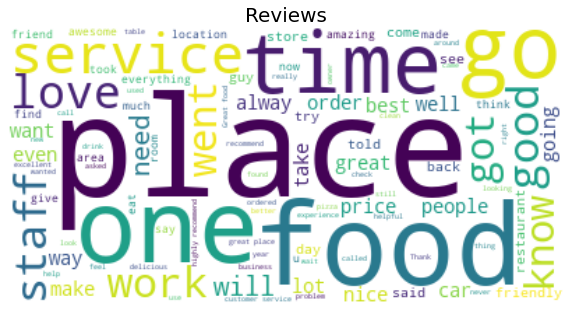

In [ ]:
review_sample = df.sample(n=500000, random_state = 1)
show_wordcloud(review_sample, "Reviews")

As one would expect from Google reviews, the most used words revolve around food and restaurants. This wordcloud is also used to identify common words which do not have any meaning for the subsequent sentiment analysis, so they can be added to our stopword list (see Appendix for the list and section 3.2 for the sentiment analysis).

<a id='enrichment'></a>
## 3. Enrichment of the data

In the following, we aim to gain a multitude of insights about the user, primarily through analyses of his or her written reviews. To make our analyses as tangible as possible, we also provide examples and visualizations throughout.

<a id='length'></a>
### 3.1 Length of Reviews

As a first analysis, we are interested in how long the reviews are. We therefore add two columns which contain the number of characters and the number of words of each review.

In [ ]:
#length in characters (excluding whitespace)
df['review_length (characters)'] = df['review'].apply(lambda x: (len(x) - x.count(" ")))
#length in words
df['review_length (words)'] = df['review'].apply(lambda x: len(x.split()))
df.head(2)

,placeID,name,lat,long,address,price_clean,country,state,username,userID,...,lang,currentPlace,education,jobs,previousPlaces,category,category1,count,review_length (characters),review_length (words)
0,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],"['Marina', 'Recreation', 'Fishing Lake']",Marina,19,213,40
1,117477090906709658119,Pins & Needles Pro Shop,33.747513,-116.998209,"2850 W Florida AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],['Bowling Supply Shop'],Bowling Supply Shop,19,142,30


In [ ]:
#longest and shortest review
print('The longest review has %d characters and %d words.' % (df['review_length (characters)'].max(),\
                                                              df['review_length (words)'].max()))
print('The shortest review has %d character and %d word.' % (df['review_length (characters)'].min(),\
                                                              df['review_length (words)'].min()))

The longest review has 3403 characters and 820 words.
The shortest review has 1 character and 1 word.


In [ ]:
#checking for the shortest review
df.loc[df['review_length (characters)'] ==1]['review']

632547    C
724332    C
Name: review, dtype: object

The longest review is 3403 characters or 820 words long. One could assume that this is an outlier, but checking manually revealed that this is not the case here. However, there are two reviews with just one letter ("C"), which will be excluded from the further analysis, as no value can be extracted from them.

In [ ]:
df = df.loc[df['review_length (characters)'] > 1]
df.shape

(1610139, 24)

**Visualizing review lenghts:** The figure below shows two histograms: To the left, the full distribution of review lengths is shown, and we can recognize  a peak of shorter reviews, as well as a long tail of few very long reviews. 
To the right side of the figure, a zoom-in shows that the bulk of reviews is about 50 characters long. It is important to note that the two histograms each use a different number of bins, which is adapted to the size of the underlying distributions. Therefore, there are differences in their appearance.

In [ ]:
#filter for shorter reviews to zoom in on the "peak" of the distribution
shorter_reviews = df.loc[df['review_length (characters)'] <= 400]

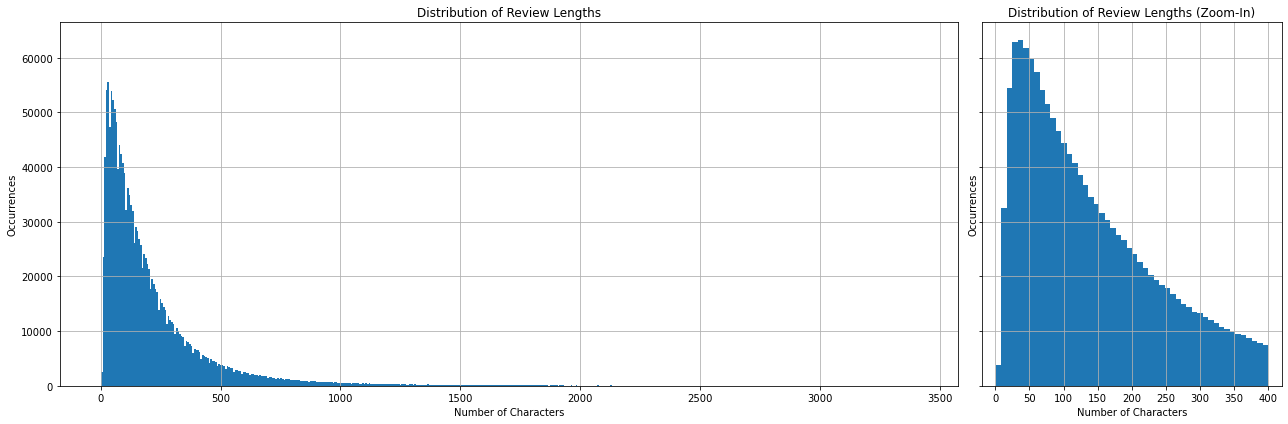

In [ ]:
#histograms for review lengths
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6), sharey = True, gridspec_kw = {'width_ratios': [3,1]})

#overall distribution
ax[0].hist(df['review_length (characters)'], bins = 500)
ax[0].set_title('Distribution of Review Lengths')
ax[0].set_xlabel('Number of Characters')
ax[0].set_ylabel('Occurrences')
ax[0].grid()

#zoom-in on the "peak"
ax[1].hist(shorter_reviews['review_length (characters)'], bins = 50)
ax[1].set_title('Distribution of Review Lengths (Zoom-In)')
ax[1].set_xlabel('Number of Characters')
ax[1].set_ylabel('Occurrences')
ax[1].grid()

fig.tight_layout()
fig.show()

<a id='sentiment'></a>
### 3.2 Sentiment Analysis: Positive, neutral, negative?
**What is the purpose?**

The goal of this sentiment analysis is to label each review as either positive, neutral or negative. 

**How does it work?**

We use the pre-trained sentiment analyzer from the NLTK package, called "VADER" (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner). In essence, VADER builds on a dictionary which maps words and lexical features (such as slang or common acronyms) to so-called valence-scores, which are then aggregated in a "compound" score [[1](https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399)]. If this score is larger than zero, a text's sentiment is positive, if not, it is negative. 
The VADER sentiment analyzer uses several heuristics, some of which are important to consider when pre-processing the review text [[1](https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399)]:  
1. **Punctuation** has an impact on the sentiment scores. These are first and foremost exclamation marks: "*the food is great!!*" gets a higher score than "*the food is great*". Therefore, exclamation marks are specifically not excluded during text pre-processing. We also found that question marks alter the score, so these also remain in the text.
2. **Capitalization** is relevant, especially in cases where words are fully capitalized: "*the food is GREAT*" scores higher  than "*the food is great*". Therefore, the common step of converting everything to lowercase during text pre-processing is explicitly skipped here. Further, we are building on the predefined stopword list from NLTK to remove common words without "value" from the text and speed up the computations. However, the importance of capitalization also means that we need to enrich this lower case stopword list with capitalized versions of the stopwords. 
3. **Negation** is recognized by the algorithm, in a sense that the polarity of the text is flipped ("*the food isn't great*" gets a negative score, as opposed to the affirmed version of the sentence. Therefore, we exclude all verbs with negations (such as "*isn't* from NLTK's stopword list).
4. **The word "*but*"** is recognized to change the sentiment of a sentence. For instance, the phrase "*the food is great but the service is terrible*" gets an overall negative score, because the second part of the sentence determines the overall meaning. Therefore, the word "*but*" is explicitly removed from the stopword list.

A final interesting heuristic of VADER is that "degree modifiers" are also taken into account - for instance, "*the food is extremely great* scores higher than "*the food is great*". This feature combined with the aforementioned ones provided a convincing argument to use this package on our Google reviews.

VADER is set to yield better results when it is not applied on a longer text, but individual sentences [[2](https://realpython.com/python-nltk-sentiment-analysis/)]. We therefore also do not remove the dot during text pre-processing, and tokenize individual sentences. We then compute an individual compound score for each sentence, and then calculate the mean to get the overall sentiment of the review.

**What are possible shortcomings?**
The greatest shortcoming in our case does not lie within the VADER algorithm itself, but the question of when a review should reasonably be labelled as "neutral". Since the sentiment score of a review is the mean of the individual scores of each sentence in it, the overall score rarely ends up to be precisely 0. We therefore checked three combinations of sentences which should overall be regarded as "neutral":

In [ ]:
text1 = "this is good. this is bad."
text2 = "love. hate."
text3 = "great. terrible."
texts = [text1, text2, text3]

sia = SentimentIntensityAnalyzer()

for idx, text in enumerate(texts):
    scores = [sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(text)]
    print('Text %d:' % (idx+1), text, np.mean(scores))

Text 1: this is good. this is bad. -0.050949999999999995
Text 2: love. hate. 0.03250000000000003
Text 3: great. terrible. 0.0741


Based on this, we decided to label a review as neutral if tis compound score falls between 0.08 and -0.08. This choice is certainly not perfect, but it is regarded as a a reasonable starting point.
As mentioned above, we exclude a range of stopwords which have no meaning for the sentiment analysis from the reviews. They also include popular words as seen in the wordloud, such as "restaurant". The list can be found in the appendix, and below we are verifying that these stopwords do not have any polarity:

In [ ]:
#check the polarity sum of the stopwords - must be zero
stopword_scores = []
for word in refined_stopwords:
    score = sia.polarity_scores(word)['compound']
    stopword_scores.append(score)
print('The polarity of the stopwords is %.2f' % sum(stopword_scores))

The polarity of the stopwords is 0.00


In [ ]:
#function for pre-processing the review text - partly inspired by Lecture 2 ("Text Analysis - Part 1 - Spam Classification")
def text_processing(text):
   
    #remove predefined punctuation -- keep exclamation and question marks, as well as dots
    #keep also apostrophes, so that negated words (e.g. "isn't") are properly recognized
    refined_punctuation = [character.replace('!', '') for character in punctuation]
    refined_punctuation = [character.replace('?', '') for character in punctuation]
    refined_punctuation = [character.replace("'", '') for character in punctuation]
    refined_punctuation = [character.replace(".", '') for character in punctuation]
    text = "".join([c for c in text if c not in refined_punctuation])

    #remove stopwords
    text = " ".join([w for w in text.split() if w not in refined_stopwords])
    
    #remove any numbers
    text = "".join(c for c in text if not c.isdigit())

    #remove any leading and trailing whitespace
    text = text.strip()
    
    return text

In [ ]:
#apply text preprocessing
df['review_clean'] = df['review'].apply(lambda x: text_processing(x))

Below, we define the function to calculate the sentiments and run it on the dataset.

In [ ]:
#function to add the sentiment score of each review
sia = SentimentIntensityAnalyzer()

def sentiment_analysis(x):
    neutral_threshold = 0.08
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in nltk.sent_tokenize(x)]
    if np.mean(sentiment_scores) > neutral_threshold:
        return 'sia positive'
    elif np.mean(sentiment_scores) >= -neutral_threshold:
        return 'sia neutral'
    else:
        return 'sia negative'

In [ ]:
#apply sentiment analysis
df['sentiment'] = df['review_clean'].apply(lambda x: sentiment_analysis(x))
df.head(2)

,placeID,name,lat,long,address,price_clean,country,state,username,userID,...,education,jobs,previousPlaces,category,category1,count,review_length (characters),review_length (words),review_clean,sentiment
0,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,"[[[], [], [], [], [], 6], [['Southern California Military Academy', 'military', [[1, 1, 1980], [...","[['mt plaza mail and ship', 'shipper', [[1, 1, 2013], [1, 1, 2013], 1], '', '']]",[],"['Marina', 'Recreation', 'Fishing Lake']",Marina,19,213,40,fishing th July. Fishing action good...but restrooms lake were disgust ing...I times year someth...,sia negative
1,117477090906709658119,Pins & Needles Pro Shop,33.747513,-116.998209,"2850 W Florida AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,"[[[], [], [], [], [], 6], [['Southern California Military Academy', 'military', [[1, 1, 1980], [...","[['mt plaza mail and ship', 'shipper', [[1, 1, 2013], [1, 1, 2013], 1], '', '']]",[],['Bowling Supply Shop'],Bowling Supply Shop,19,142,30,ball drilled. Excellent service. Joel very attentive individual needs. Best fitting ball long ti...,sia positive


Visualizations and further analyses regarding the sentiments can be found in section 4.

<a id='emotionality'></a>
### 3.3 Emotionality Analysis

**What is the purpose?**

Having labelled each review as positive, neutral or negative, we now wish to become more nuanced and extract specific emotions from the reviews. This can be used to gain more information about the reviewer.

**How does it work?**

We use the NRC Word-Emotion Association Lexicon ("NRCLex"). This is a dictionary containing emotion associations for a wide range of English words. Words can be associated with one or more of eight "basic" emotions: Fear, anger, anticipation, trust, joy, sadness, disgust and surprise. Further, the sentiments "positive" and "negative" are also connected to the words. The dictionary was created using a crowdsourcing approach via Amazon's Mechanical Turk. [[3](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)]

Further details on this appproach can be found in the [original paper](https://arxiv.org/pdf/1308.6297.pdf), and an interactive visualization of the words and associated emotions is accessible [here](https://arxiv.org/pdf/1308.6297.pdf).

To make this lexicon applicable for our purposes, we now need to convert all reviews to lowercase so matches can be found with the dictionary. All punctuation is removed except apostrophes, to maintain the original words. For computational efficiency, we again remove numbers and stopwords, but this time we only use the predefined stopwords from NLTK, since some of the words from our refined stopword list have emotional value (such as "food"). Because the algorithm only looks at the words in the given texts and aggregates their emotionality scores, there is no need for tokenization.

**What are possible shortcomings?**
One important shortcoming is that the algorithm is largely insensitive to context, as it only checks whether the words in the review are associated with any emotionality values. This means that for instance negation is not regognized ([[4](https://arxiv.org/pdf/1308.6297.pdf)]), in contrast to the previously used SentimentIntensityAnalyzer. The insensitivity to context also means that neutral names (such as "war museum") can be associated with an emotion. Below, some examples of these issues are provided.

Another shortcoming is that some frequent words from the reviews have no correspondence in the dictionary. One example of this is the word "great", which is a reasonably prominent word as shown in the wordcloud above.

In [ ]:
text1 = 'good'
text2 = 'not good'
text3 = "can't go wrong"
text4 = 'war museum'
texts = [text1, text2, text3, text4]

for text in texts:
    emotion = NRCLex(text)
    print('Text: ', text, emotion.top_emotions)

Text:  good [('trust', 0.2), ('surprise', 0.2), ('positive', 0.2), ('joy', 0.2), ('anticipation', 0.2)]
Text:  not good [('trust', 0.2), ('surprise', 0.2), ('positive', 0.2), ('joy', 0.2), ('anticipation', 0.2)]
Text:  can't go wrong [('negative', 1.0)]
Text:  war museum [('fear', 0.5), ('negative', 0.5)]


Despite these shortcomings, we still chose to go forward with the NRC Emotion Lexicon. This is because on the one hand, it has shown to be one of the most extensive dictionaries for emotion analysis, and provides a good starting point for text analysis without having to resort to supervised learning. On the other hand, our ultimate goal is to gather information about the **reviewers**, and not the reviews themselves. We are therefore less interested in correctly labelling the reviews, but more interested in looking at the **choice of words** from the reviewers. We argue that this analysis in combination with the following readability and profanity checks still allows us to extract a good amount of insights about the users just from their reviews.

In [ ]:
#function for processing the review text - partly inspired by Lecture 2 ("Text Analysis - Part 1 - Spam Classification")
def text_processing_emotion(text):    

    # lowercase
    text = "".join([c.lower() for c in text])

    #stopwords - we only use the stopword list from NLTK, since some words from our previous enriched list have emotional value
    text = " ".join([w for w in text.split() if w not in stop_words])

    # remove punctuation
    refined_punctuation_emotions = [character.replace("'",'') for character in punctuation]
    text = "".join([c for c in text if c not in refined_punctuation_emotions])
    
    #remove any numbers
    text = "".join(c for c in text if not c.isdigit())

    #remove any leading and trailing whitespace
    text = text.strip()
    
    return text

In [ ]:
#apply pre-processing 
df['reviews_processed_emotion'] = df['review'].apply(lambda x: text_processing_emotion(x))

Below, we define the function to calculate the emotionality scores and run it on the dataset.

In [ ]:
#function to add the score for each individual emotion and sentiment 
def emotion_analysis(x, emotion):

    emotions = NRCLex(x)
    emotion_dict = emotions.affect_frequencies
    score = emotion_dict.get(emotion)
    
    if score:
        return score
    else: 
        return 0.0

In [ ]:
#apply emotionality analysis and create new columns with the emotionality scores of each review
df['fear'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'fear'))

df['anger'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'anger'))

df['anticipation'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'anticipation'))

df['trust'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'trust'))

df['surprise'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'surprise'))

df['sadness'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'sadness'))

df['disgust'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'disgust'))

df['joy'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'joy'))

df['positive (EmoLex)'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'positive'))

df['negative (EmoLex)'] = df['reviews_processed_emotion'].apply(lambda x: emotion_analysis(x,'negative'))

Finally, we aggregate the emotions to get the "total emotionality" of a review, asadditional information about the user. We also sum positive and negative emotions. A caveat here is that the emotion "surprise" is ambivalent and can have both a positive and a negative connotation. Therefore, the sum of negative emotions contains one more element than the sum of positive emotions.

In [ ]:
#getting the "total emotionality" of a review
df['emotion_sum'] = df['fear']+df['anger']+df['anticipation']+df['trust']+df['surprise']+df['sadness']+df['disgust']+df['joy']

#summing positive and negative emotions
df['sum_positive_emotions'] = df['anticipation']+df['trust']+df['joy']
df['sum_negative_emotions'] = df['fear']+df['anger']+df['sadness']+df['disgust']

Further analyses regarding the emotions together with sentiments can be found in section 4.

<a id='readability'></a>
### 3.4 Readability Analysis
**What is the purpose?**
We wish to gain insights into how complex a review is written. This will for instance be used later on for making inferences about the reviewer's education.

**How does it work?**
We use the "textstat" library, which offers the feature of adding a school-grade level that is needed to understand the review. For instance, a score of 6.0 would mean that the review can be understood by a 6th-grader. The function "text_standard" was chosen, since it aggregates a variety of different reading scores [[5](https://pypi.org/project/textstat/)]. We therefore concluded that this would to provide the most robust estimate. Further, no text-preprocessing was required before using the function. 

**What are possible shortcomings?**
In some cases, the returned readability scores are unreasonably high. This happens for instance when words in a review are misspelled. This is illustrated below, where a misspelled version of the word "possible", as found in one of the reviews, is assessed.

In [ ]:
print('Misspelled version: Grade', ts.text_standard('possibell', float_output = 'True'))
print('Correctly spelled version: Grade', ts.text_standard('possible', float_output = 'True'))

Misspelled: Grade 20.0
Correctly spelled: Grade  1.0


In [ ]:
low_readability_score = df.loc[df['readability'] < 25]
high_readability_score = df.loc[df['readability'] >= 25]

In [ ]:
print("Number of 'reasonable' readability reviews:", len(low_readability_score['readability']))

Number of 'reasonable' readability reviews 1608451


In [ ]:
print("Number of 'very hard' readability reviews:", len(high_readability_score['readability']))

Number of 'very hard' readability reviews: 1688


Even though it would have been possible to use autocorrect functions on the text, it was decided to not use these. This is because when words are misspelled, this also tells us something about the reader. A high readability score may thereby not correpond to a complex sentence, but poorly used language. Also, the fraction of unreasonably high readabillity scores is overall low.

Below, we define the function to calculate the readability score and run it on the dataset.

In [ ]:
#function for readability score
def readability_score(x):
    score = ts.text_standard(x, float_output = True)
    return score

In [ ]:
#apply readability function
df['readability'] = df['review'].apply(lambda x: readability_score(x))

<a id='profanity'></a>
### 3.5 Profanity/Swearwords

**What is the purpose?** As a final tool for text analysis, we assess the use of profanity/swearwords in the text. This is also used later to make prediction about a reviewer's education, as well as gender. An interesting question here is for instance whether men swear more than women.

**How does it work?** We use the "Alt-profanity-check" package, which enables checking for offensive language in text. Contrary to for instance the previously used NRCLex, it does not rely on a dictionary to match swearwords, but uses an underlying machine learning model on around 200.000 samples labelled by human readers [[6](https://pypi.org/project/alt-profanity-check/)]. As such, it is much more robust to variations in language, and also does not require pre-processing of the text. For each review, we return a score between 0 and 1, which indicates the probability of the review being offensive (1 = offensive).

**What are possible shortcomings?** Like all applications for text analysis, this package also does not recognize everything perfectly. For instance, variations of swearwords that are less common will not be picked up by the algorithm (like "f4ck you") [[6](https://pypi.org/project/alt-profanity-check/)]. However, we still deemed this algorithm to be useful, as we do not expect these variations to be very common in the reviews.

In [ ]:
#to give just two examples of the profanity check
print('Have a nice day!:', predict_prob(['Have a nice day!'])[0])
print('Go to hell!:', predict_prob(['Go to hell!'])[0])

Have a nice day!: 0.06796895633926123
Go to hell!: 0.9800927720526497


Below, we define the function to calculate the profanity score and run it on the dataset.

In [ ]:
#function for profanity score
def profanity(x):
    profanity_value = predict_prob([x])
    return profanity_value[0]

In [ ]:
#apply profanity function
df['profanity_value'] = df['review'].apply(lambda x: profanity(x))

<a id='gender'></a>
### 3.6 Adding Gender Information

Next, we try to add the information whether the reviewer is male or female. To do this, we add an external dataset from the US Social Security Administration [[7](https://www.ssa.gov/oact/babynames/limits.html)] containing the most popular baby names in the US in the year 1985. Since most of our reviews were written around 2010, we argue that the names of the reviewers match the birth names reasonably well, assuming that many reviewers are in their late twenties.

First, we need to extract the reviewers' first name, and then convert it to lowercase for uniformity.

In [ ]:
#function to get the first name from every reviewer, in lowercase
def firstname(x):
    name = x.split()[0]
    #put all first names in lowercase
    name = name.lower()
    return name

In [ ]:
#apply function for finding the first name
df['name'] = df['username'].apply(lambda x: firstname(x))

Below, we read in the name data:

In [ ]:
#read in data that contains popular names for males and females in the US
us_names = pd.read_table('yob1985.txt', delimiter = ',', names = ['name','gender','count'])
us_names.head(2)

,name,gender,count
0,Jessica,F,48347
1,Ashley,F,47006


Occasionally, the same name was given to birth girls and boys. We solved this situation by sorting all names according to popularity, and then dropping name duplicates such that the more popular name is kept. Thereby, if the same name was given more often to girls than boys, we would label this name as "female". This is of course not entirely accurate, but we deemed this simple approach as sufficient for our purposes.

In [ ]:
#handle names that are given to both males and females
us_names = us_names.sort_values(by = ['count'], ascending = False)
us_names = us_names.drop_duplicates(subset='name', keep="first")

#also convert US names to lowercase
us_names['name'] = us_names['name'].apply(lambda x: firstname(x))
us_names.head(2)

,name,gender,count
12502,michael,M,64924
12503,christopher,M,59613


Finally, we merge the names with our dataframe. We use a left merge, so that no user data is lost. 

In [ ]:
#add the gender information to the reviews dataset using a left merge
df = df.merge(us_names, on = 'name', how = 'left')

We see that more than twice as many reviews have been written by men than women:

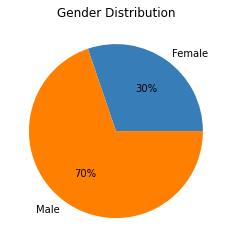

In [ ]:
labels = ['Female','Male']
plt.pie(df["gender"].value_counts().sort_index(), autopct="%1.f%%", labels = labels, colors = CB_colors)
plt.title("Gender Distribution")
plt.show()

<a id='education'></a>
### 3.7 Adding Education

With the following code, we wish to get the information, if somebody obtained higher education or not. It searches for key words in the column "education" of the user data:

In [ ]:
liste = ["Uni", "uni", "College", "college", "Institute", "institute", "School", "PhD", "BS", "MS", "Physics", "physic", 
         "Chemistry", "chem", "Biology", "Engineering", "engineering", "UC", "Science", "science", "Mathematics", "Law", 
         "law", "Master", "Bachelor", "Technology", "Stanford", "Camebridge", "MIT", 'Caltech', "NYU", "Math", "math", "bio"
        "BA", "MA", "Academic", "academic", "Student", "student", "EPFL", "Tech", "tech", "nyu", "Academia", "Penn State"]

def uni(row):
    for word in liste:
        if pd.isna(row) == False:
            if word in row: # we return "1", if one of the words in the list appears in the column
                return 1
        else:
                return "Unknown"
    
    return 0 #otherwise, we return 0
    
df["university"] = df["education"].apply(uni)

First, we analyze all the data, event though we know that by doing this, we include everbody who did not provide information about their education to Google. We hereby assume that these people do not have higher education (meaning that the column "Unversity" = 0)

In [ ]:
df["university"].value_counts()

0          891686
1          398577
Unknown    319876
Name: university, dtype: int64

In [ ]:
df[df["university"] == 0]["readability"].mean()

6.145134049429957

In [ ]:
df[df["university"] == 1]["readability"].mean()

6.308552676145387

The readability column, which was obtained earlier, tells us how gramatically complex the written review is. We see that there are only minor differences in the mean between people who went to university, and those who did not. Therefore, we check if this gap is growing when only those are included who actually wrote something about their education. Also, "Unknown" values will be excluded.

In [ ]:
df_test = df[(df["education"] != "[[[], [], [], [], [], 6], []]") & (df["education"] !="[[], []]") &(df["education"] !=0)]

In [ ]:
print("Mean readability score no university:", df_test[df_test["university"] == 0]["readability"].mean())
print("Mean readability score university:", df_test[df_test["university"] == 1]["readability"].mean())

Mean readability score no university: 5.7607045521093765
Mean readability score university: 6.308552676145387


We see that the gap in readability grew slightly, so we can assume an underlying correlation between education and readability of the reviews. However, we need to keep in mind that readability is also higher when words are misspelled, so we cannot automatically conclude that users with a university education automatically write more complex sentences. However, the fact that users with university education also tend to write longer reviews (see below) supports this claim.

In [ ]:
print("Mean review length no university:", df_test[df_test["university"] == 0]["review_length (words)"].mean())
print("Mean review length university:", df_test[df_test["university"] == 1]["review_length (words)"].mean())

Mean review length no university: 41.12834200509043
Mean review length university: 48.720503190098775


<a id='sanitycheck'></a>
## 4. Analyses and Sanity Check of Sentiments and Emotion Scores

In the following, we show some preliminary analyses of the now acquired sentiments and emotionality scores. Since the sentiments were created from a different package than the emotions (VADER Lexicon vs NRCLex), we are especially interested in seeing whether the results correlate. Through this, we hope to become even more confident in our data.

It is important to mention that the NRCLex also returns a sentiment. However, as discussed above, the NRCLex is less sensitive to the context within a sentence than the SentimentIntenstityAnalyzer (sia) based on VADER. Therefore, it was chosen to mainly investigate the sentiments from the NRCLex here.

The piechart below clearly shows that most of the reviews are written with a positive sentiment:

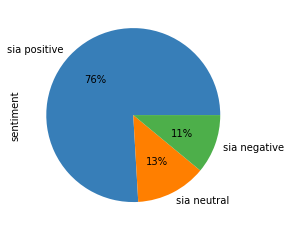

In [ ]:
df['sentiment'].value_counts().plot(kind="pie", autopct="%1.f%%",colors = CB_colors);

As a first reliability check, we want to see if the sentiments (negative, neutral, positive) obtained using VADER ("sia") have corresponding mean ratings. For instance, one would assume that positive sentiments correspond to higher ratings are higher than neutral or negative sentiments:

In [ ]:
df.groupby("sentiment")['rating'].mean()

sentiment
sia negative    2.232479
sia neutral     3.097705
sia positive    4.407766
Name: rating, dtype: float64

As expected, we found distinct mean ratings for the different sentiments. 
Next, we investigate the relationship between review length (in words and characters) and sentiment. Positive reviews are shorter than negative ones. One possible reason for this may be that more words are needed to elaborate on a negative review to explain what a person dislikes. Neutral sentiments are longest, which can be explained by the fact that the used algorithm averages scores of distinct sentences in the review. With more sentences, there is a higher chance of the average getting close to zero.

In [ ]:
df.groupby("sentiment")['review_length (words)'].mean()

sentiment
sia negative    57.496663
sia neutral     65.259937
sia positive    45.001814
Name: review_length (words), dtype: float64

In [ ]:
df.groupby("sentiment")['review_length (characters)'].mean()

sentiment
sia negative    249.955929
sia neutral     282.668405
sia positive    200.915518
Name: review_length (characters), dtype: float64

For our further analysis, we create three different datasets corresponding to each sentiment, and look for differences.

In [ ]:
#gather negative, neutral and positive sentiment
negatives = df[df.sentiment == "sia negative"]
neutrales = df[df.sentiment == "sia neutral"]
positives = df[df.sentiment == "sia positive"]

In [ ]:
emotion_columns = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy',
       'positive (EmoLex)', 'negative (EmoLex)', 'emotion_sum', 'sum_positive_emotions', 'sum_negative_emotions']

In [ ]:
#calculate the means of the emotionality values
negative_means= negatives[emotion_columns].mean()
neutrales_means = neutrales[emotion_columns].mean()
positives_means = positives[emotion_columns].mean()

In [ ]:
#create a dataframe with the mean values for plotting
emotions = pd.DataFrame()
emotions["positives"] = positives_means
emotions["neutrales"] = neutrales_means
emotions["negatives"] = negative_means

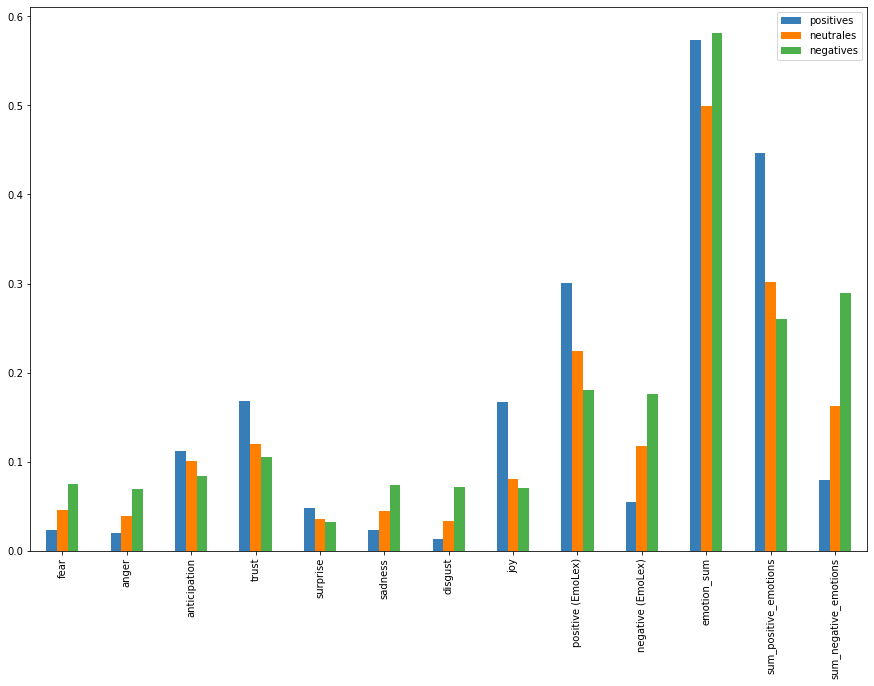

In [ ]:
emotions.plot(kind="bar", figsize=(15,10), color = CB_colors);

The graph reveals that the method to obtain emotionality values is working as expected. In almost all emotions, we see that the naturally expected sentiment is dominant. Also, the "emotion_sum" (the sum of all the emotions obtained) is nearly twice as high for the data with positive or negative sentiment as for the dataset with neutral sentiments. Positive emotions like trust and joy are highest for the positive dataset, and negatives emotions likewise. But we also see that there are also parts of positive emotions in negative reviews and vice versa. This can be seen as a mistake, but it does also make sense that a review is neither entirely negative nor positive. Emotionality is shaded, and different emotions are existent at any time in a person.

Next, we investigate the connection between ratings (on a scale of 1-5, 5 is best) and sentiments:

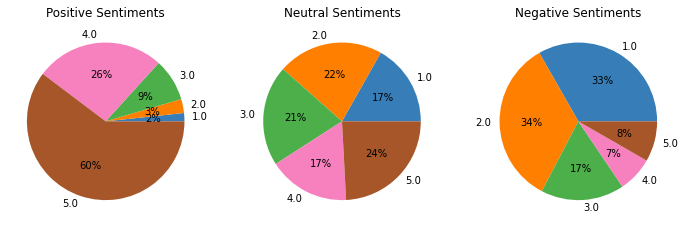

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (12,6))
labels = [1.0,2.0,3.0,4.0,5.0]
ax[0].pie(positives["rating"].value_counts().sort_index(), autopct="%1.f%%", labels = labels, colors = CB_colors)
ax[0].set_title("Positive Sentiments")

ax[1].pie(neutrales["rating"].value_counts().sort_index(), autopct="%1.f%%", labels = labels, colors = CB_colors)
ax[1].set_title("Neutral Sentiments")

ax[2].pie(negatives["rating"].value_counts().sort_index(), autopct="%1.f%%", labels = labels, colors = CB_colors)
ax[2].set_title("Negative Sentiments")

fig.show()

It can be seen that the sentiments and ratings generally match. Positive sentiments are associated with more high ratings, and negative sentiments tend to be connected to lower ratings. The picture is mixed for the neutral sentiments. We argue that this picture can however change depending on the neutrality threshold as defined in the sentiment analysis.

<a id='profiles'></a>
## 5. Creation of the User Profiles

In the following, we use all the previously gathered information to create user profiles. This results in a table where each user has one row, and the following information is gathered about them: 

**Personal information:**
Gender, first name, university education

**Behaviour information:**
Number of reviewed places, mean and max price of visited places, places of interest (=all reviewed categories of places), mean rating, minimum rating, mean and max review_length (characters), relevant US states, relevant places

**"Psychological" information:**
top_sentiment, mean fear, mean anger, mean_anticipation, mean trust, mean surprise, mean sadness, mean disgust, mean joy, mean emotion sum, mean positive emotions, mean negative emotions, top emotion associated with "favourite" category, mean readability, mean profanity 

In [ ]:
# group the relevant data per user to get information about the ratings, price preferences and interests (categories of places visited)
user_prof = df.groupby('userID').agg({'gender':['max'], 'sentiment':['max'], 'rating':['mean','min'],
                                      'review_length (characters)':['mean','max'],'fear':['mean'], 'anger':['mean'],
                                      'anticipation':['mean'], 'trust':['mean'], 'surprise':['mean'],
                                      'sadness':['mean'], 'disgust':['mean'], 'joy':['mean'],'emotion_sum':['mean'],
                                      'sum_positive_emotions':['mean'], 'sum_negative_emotions':['mean'],
                                      'readability':['mean'], 'profanity_value':['mean'], 'placeID':pd.Series.nunique,
                                      'name':'first','price_clean':['mean','max'], 'category1':list, 'university': ['max']}).reset_index()

In [ ]:
#rename the columns
user_prof.columns = ['userID', 'gender', 'top_sentiment', 'mean_rating', 'min_rating', 'mean_review_length (characters)', 'max_review_length (characters)', 'mean_fear',\
                     'mean_anger', 'mean_anticipation','mean_trust','mean_surprise', 'mean_sadness','mean_disgust','mean_joy','mean_emotion_sum','mean_positive_emotions',\
                    'mean_negative_emotions','mean_readability', 'mean_profanity', 'number_reviewed_places', 'first_name', 'mean_price', 'max_price', 'interest','university_education']http://localhost:8888/notebooks/Documents/Studium/Master/13%20Weeks%20Spring%2022/42578%20Advanced%20Business%20Analytics/ABA%20Project/2.%20Creation%20of%20User%20Profiles.ipynb#Addition-to-user-profiles:

In [ ]:
# get a user's top category (with the highest rating)
user_top_1 = df.groupby(['userID', 'category1']).agg({'rating':'first'}).reset_index()
user_top_1 = user_top_1.sort_values(by='rating', ascending=False).drop_duplicates('userID').sort_index().rename(columns={'category1':'top_category'})

In [ ]:
# merge the grouped frame together to get one user profile
user_prof = pd.merge(user_prof, user_top_1, on='userID')

<a id='highlevel'></a>
### 5.1 Addition 1 to user profiles (high-level categories): 
High-Level categories - the categories of the places (such as "Pizza Restaurant", "Steak House" etc.) are very diverse, so we attempt to group them a bit more in the following. For instance, the two examples that were just mentioned can both be labelled as "restaurant".

In [ ]:
def find_category(x):
    if 'Restaurant' in x or 'Steak House' in x:
        return 'Restaurant'
    elif 'Sandwich Shop' in x or 'Coffee Shop' in x:
        return 'Takeaway'
    elif 'Supermarket' in x or 'Grocer' in x:
        return 'Groceries'
    elif 'Bar' in x or 'Pub' in x:
        return 'Bar'
    elif 'Shopping' in x:
        return 'Shopping'
    elif 'Service' in x or 'Plumber' in x:
        return 'Services'
    elif 'Hotel' in x or 'Motel' in x or 'Resort' in x:
        return 'Overnight Stay'
    elif 'Tire' in x or 'Car' in x or 'Auto' in x or 'Toyota' in x or 'Ford' in x or 'Transmission' in x:
        return 'Automotive'
    elif 'Park' in x:
        return 'Park'
    elif 'Physician' in x or 'Dentist' in x or 'Doctor' in x or 'Pharma' in x or 'Health' in x:
        return 'Health'
    elif 'Skin' in x or 'Salon' in x or 'Hair' in x:
        return 'Personal Grooming'
    elif 'Veterinarian' in x:
        return 'Veterinarian'
    elif 'Movie' in x or 'Theater' in x or 'Cinema' in x or 'Comedy' in x:
        return 'Entertainment'
    elif 'Night Club' in x or 'Strip Club' in x or 'Adult Entertainment' in x or 'Sex' in x:
        return 'Adult Entertainment'
    elif 'Real Estate' in x or 'Property' in x:
        return 'Real Estate'
    elif 'Tattoo' in x:
        return 'Tattoo'
    elif 'Self-Storage' in x:
        return 'Self-Storage'
    elif 'University' in x or 'School' in x:
        return 'Education'
    elif 'Lesbian' in x:
        return 'Lesbian/Gay Organization'
    else:
        return 'Other'

In [ ]:
#applying the function to find high-level categories
user_prof['top_category_highlevel'] = user_prof['top_category'].apply(lambda x: find_category(x))

Below, we give an impression over the highlevel categories. The largest category is still other, since the categories of places are indeed very varied. But for instance the fact that the second most popular category is restaurants is in line with the wordcloud at the beginning of this notebook. Another finding from our process of creating high-level categories is that some reviewers also review places which allow for an inference of their sexuality, such as gay bars. This is highly private information, which however is (unknowingly?) shared by the users. 

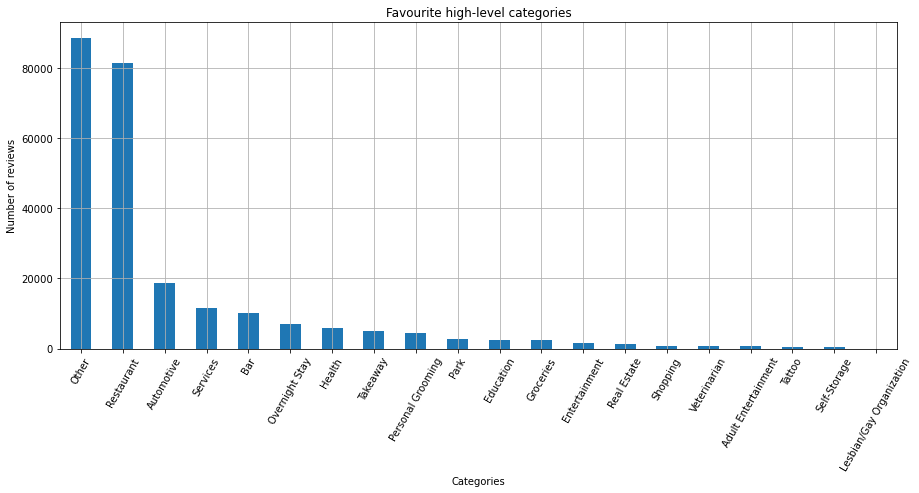

In [ ]:
fig = user_prof['top_category_highlevel'].value_counts().plot(kind='bar', figsize = (15,6))
fig.set_xticklabels(fig.get_xticklabels(), rotation = 60)
fig.set_title('Favourite high-level categories')
fig.set_xlabel('Categories')
fig.set_ylabel('Number of reviews')
fig.grid()
plt.show()

<a id='top_emotion'></a>
### 5.2 Addition 2 to user profiles (top emotion for top category):  
Emotion associated with a reviewer's top or "favourite" category - we also want to find out which emotion a user connects with their top (=highest rated) category.

In [ ]:
# Getting the the needed columns
user_prof_2=user_prof[['userID', 'top_category']]
df_user_prof = pd.merge(df, user_prof_2, on='userID')

In [ ]:
# getting only the top category rows
only_favourites=df_user_prof.iloc[:, :][df_user_prof['category1'] == df_user_prof['top_category']]

In [ ]:
# getting the mean values for each user
grouped_emotion = only_favourites.groupby('userID').agg({'name':'first', 'sentiment':'first',
       'fear':'mean', 'anger':'mean', 'anticipation':'mean', 'trust':'mean',
       'surprise':'mean', 'sadness':'mean', 'disgust':'mean', 'joy':'mean', 'positive (EmoLex)':'mean',
       'negative (EmoLex)':'mean', 'emotion_sum':'mean', 'mean_rating':'first',
       'top_category':'first', 'top_sentiment':'first'}).reset_index()

In [ ]:
# Strongest emotion for top category 
grouped_emotion['top_cat_emo']= grouped_emotion.iloc[:, 3:11].idxmax(axis=1)
#check indices

In [ ]:
#preparing the grouped emotions for merging them back to the user profiles - we are just interested in 'top_cat_emo'
top_emo_merge=grouped_emotion.drop(columns=['name', 'sentiment', 'fear', 'anger', 'anticipation', 'trust',
       'surprise', 'sadness', 'disgust', 'joy', 'positive (EmoLex)',
       'negative (EmoLex)', 'emotion_sum', 'mean_rating',
       'top_category', 'top_sentiment'])

In [ ]:
# merge the data together to get one user profile
user_prof = pd.merge(user_prof, top_emo_merge, on='userID')

<a id='top_states'></a>
### 5.3 Addition 3 to user profiles (top states and places):
Top states and places for each user - in the following, we get the top US states and places in which the users have been. This information can for instance be used for "tracking" purposes.

A more precise analysis has been made in the notebook 3 "User Profile analysis", in which the top places of the users are geographically clustered to detect potentially long stays.

In [ ]:
def get_top_states_places(df, min_reviews=0):
    """
    Returns a df with each user and a list with their top states

    :param df: df with all the reviews, users, states etc.
    :param min_reviews: at least those reviews in each state. If min_reviews=0 (default), it will add every state in which a user did a review.
    :return: df with every user and 2 columns with top_states and places.
    """

    print("Getting top states")
    df_count = df.groupby(by=["userID", "state"]).size().reset_index(name="reviews_in_state")
    df_count = df_count[df_count["reviews_in_state"] >= min_reviews]
    df_top_states = df_count.groupby("userID")["state"].apply(list).reset_index()

    # Merging with all users that might have been out of the count
    # This way you will have every user in the df.
    if min_reviews > 0:
        df_all_users = pd.DataFrame(data={"userID": df.userID.unique()})
        df_top_states = df_all_users.merge(df_top_states, how="left")
        
    
    print("Getting places")
    df_places = df.groupby(by=["userID"])["placeID"].apply(list).reset_index()
    df_places = df_places.rename(columns={"placeID": "placeIDs"})
    
    # Merging with the top states, since it has all the users: inner join and there is no
    # loss of users
    df_top_states = df_top_states.merge(df_places, on="userID")
    return df_top_states.rename(columns={"state": "top_states"})


ret = get_top_states_places(df)
ret.head()

In [ ]:
#adding this information the user profile dataframe
user_prof = user_prof.merge(ret, on="userID")

In [ ]:
#showing the final user profile dataframe
df_users.head()

,userID,gender,top_sentiment,mean_rating,min_rating,mean_review_length (characters),max_review_length (characters),mean_fear,mean_anger,mean_anticipation,...,mean_price,max_price,interest,university_education,top_category,rating,top_category_highlevel,top_cat_emo,top_states,placeIDs
0,100000032416892623125,M,sia positive,4.666667,4,186.500000,678,0.052083,0.041667,0.129808,...,2.333333,3.0,"['Chinese Restaurant', 'European Restaurant', ...",0,Barbecue Restaurant,5,Restaurant,trust,[' CA'],"['116585428624152564242', '1094200330908103280..."
1,100000053212755369563,M,sia neutral,2.000000,2,235.250000,459,0.034188,0.026709,0.067308,...,2.750000,3.0,"['Restaurant', 'Restaurant', 'American Restaur...",0,Restaurant,2,Restaurant,trust,"[' FL', ' MS']","['100073820849130920147', '1035191658417626213..."
2,100000106576186066497,F,sia positive,5.000000,5,84.666667,106,0.083333,0.083333,0.500000,...,2.500000,3.0,"['Fast Food Restaurant', 'Sushi Restaurant', '...",1,Espresso Bar,5,Bar,anticipation,[' CA'],"['109700398636326253569', '1119710883960542391..."
3,100000122158721897485,M,sia positive,3.333333,2,165.333333,216,0.030303,0.030303,0.141414,...,3.000000,3.0,"['Latin American Restaurant', 'Chicken Restaur...",0,Chicken Restaurant,5,Restaurant,anticipation,[' CA'],"['101788547508969264434', '1019596231878271029..."
4,100000202208212354964,M,sia positive,5.000000,5,384.000000,675,0.052083,0.031250,0.139583,...,2.000000,2.0,"['Auto Glass Shop', 'Garden Center', 'Coffee S...",1,Auto Glass Shop,5,Automotive,fear,[' NC'],"['103340747374180675968', '1134435810559727883..."


<a id='conclusion'></a>
## 6. Conclusion

We have applied a bundle of open-source text analysis tools and table calculations, and used extra data to add a variety of information to the users and thereby create user profiles. We have also seen that especially the tools used for language analysis each have their individual drawbacks, the improvement of which is recommended for future applications. However, we argue that we have created a reasonable baseline, and will further analyze the now created user profiles in notebook 3.

<a id='ref'></a>
## 7. References

[1] Hutto, C. J.; Gilbert, E. (2014): "VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text", In: Proceedings of the Eighth International AAAI Conference on Weblogs and Social Media, https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399, retrieved on 05.05.2022

[2] Mogyorosi, M. (2021): "Sentiment Analysis: First Steps With Python's NLTK Library", https://realpython.com/python-nltk-sentiment-analysis/, retrieved on 10.04.2022

[3] Mohammad, S. M. (2022): "NRC Word-Emotion Association Lexicon", http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm, retrieved on 11.04.2022

[4] Mohammad, S. M.; Turney, P. D. (2013): "Crowdsourcing a Word–Emotion Association Lexicon", https://arxiv.org/pdf/1308.6297.pdf, retrieved on 11.04.2022

[5] Python Software Foundation (2022): "Textstat", https://pypi.org/project/textstat/, retrieved on 25.04.2022

[6] Python Software Foundation (2022): "Alt-profanity-check", https://pypi.org/project/alt-profanity-check/, retrieved on 05.05.2022

[7] Social Security Administration (2022): Beyond the Top 1000 Names / National Data, https://www.ssa.gov/oact/babynames/limits.html, retrieved on 28.04.2022

<a id='append'></a>
## 8. Appendix

If any of the code above is to be run, the following cells must be executed first.

In [ ]:
#necessary installations and downloads
!pip install nltk
!pip install stopwords
!pip install NRCLex
!pip install textstat
!pip install alt-profanity-check
!pip install sklearn --upgrade
nltk.download('punkt')
nltk.download('vader_lexicon')

In [ ]:
#necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#text processing and sentiment analysis
import wordcloud
from stopwords import get_stopwords
stop_words=get_stopwords('en')
import string
from string import punctuation
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

#emotionality analysis
from nrclex import NRCLex
from profanity_check import predict, predict_prob
import textstat as ts

#machine learning
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import plot_tree
from sklearn import tree

#filter warnings
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#colour pallette optimized for colour-blindness
CB_colors= ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [ ]:
#list of stopwords to be exluded from the reviews for the sentiment analysis
refined_stopwords = ['', 'a', 'A', 'about', 'above', 'after', 'again', 'against', 'all', 'am',\
'About', 'Above', 'After','Again', 'Against','All', 'Am',\
'an','An', 'and','And', 'any','Any',\
'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'between', 'both', 'by',\
'Are', 'As', 'At', 'Be', 'Because', 'Been', 'Before', 'Being', 'Between', 'Both', 'By',\
'could','Could', 'did', 'do','Did','Do','does','Does','doing','Doing','during','During', 'each','Each',\
'few', 'for', 'from', 'further','Few','For','From','Further',\
'had', 'has', 'have', 'having', 'Had', 'Has', 'Have', 'Having','he','He', "he'd","He'd", "he'll","He'll",\
"he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm",\
"He's", 'Her', 'Here', "Here's", 'Hers', 'Herself', 'Him', 'Himself', 'His', 'How', "How's", 'I', "I'd", "I'll", "I'm",\
'get','Get','got','Got','go','Go', "I've","i've",\
'if','is','in', 'into', 'its',"it's", 'itself', "let's", 'me', 'more', 'most', 'my',\
'If','Is','In', 'Into', 'Its',"It's", 'Itself', "Let's", 'Me', 'More', 'Most', 'My',\
'myself', 'nor', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our','one',\
'Myself', 'Nor', 'Of', 'Off', 'On', 'Once', 'Only', 'Or', 'Other', 'Our','One',\
'over', 'own', 'same', 'she', "she'd", "she'll", "she's", 'some', 'than',\
'Over', 'Own', 'Same', 'She', "She'd", "She'll", "She's", 'Some', 'Than',\
'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there',\
'That', "That's", 'The', 'Their', 'Theirs', 'Them', 'Themselves', 'Then', 'There',\
"there's", 'these', 'they',"There's", 'These', 'They',\
"they'd","they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'should', 'under', 'until',\
"They'd","They'll", "They're", "They've", 'This', 'Those', 'Through', 'To', 'Too', 'Should', 'Under', 'Until',\
'was','Was','went','Went','we','We',\
"we'd", "we'll", "we're", "we've", 'what', "what's", 'when', "when's", 'where', "where's", 'which',\
"We'd", "We'll", "We're", "We've", 'What', "What's", 'When', "When's", 'Where', "Where's", 'Which',\
'while', 'who', "who's", 'whom', 'why', "why's", 'with',\
'While', 'Who', "Who's", 'Whom', 'Why', "Why's", 'With',\
'would','Would', 'you', 'You', "you'd", "You'd", "you'll", "You'll", "you're","You're",\
"you've","You've", 'your','Your', 'yours','Yours', 'yourself','Yourself', 'yourselves','Yourselves',\
'restaurant', 'bar', 'pizza', 'food', 'coffee', 'location', 'service', 'staff', 'work', 'always', 'time', 'even', 'day',\
'Restaurant', 'Bar', 'Pizza', 'Food', 'Coffee', 'Location', 'Service', 'Staff', 'Work', 'Always', 'Time', 'Even', 'Day',\
'customer','Customer','now','Now','area','Area',\
'BBQ','bbq','place','mexican','tacos','review','one','work','time','new','know','even','people','room','price','back','said',\
'Place','Mexican','Tacos','Review','One','Work','Time','New','Know','Even','People','Room','Price','Back','Said']